<a href="https://colab.research.google.com/github/titika2013/Made_adv_DL/blob/main/homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №2


In [ ]:
import numpy as np
import gym
import random
from tqdm.notebook import tqdm
from collections import defaultdict
import copy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

import seaborn as sns
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline


In [ ]:
%%capture
pip install latex

In [ ]:
N_ROWS = 3  # @param {type:"number"}
N_COLS = 3  # @param {type:"number"}
N_WIN = 3  # @param {type:"number"}


In [ ]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None

        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x + 1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i, j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i, j:j + self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([self.board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                if np.all(np.array([self.board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                    return True
        return False

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
            self.gameOver = True
            return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----' * (self.n_cols) + '-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----' * (self.n_cols) + '-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1


In [ ]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i, a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text(a[1], a[0], "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center',
                        verticalalignment='center', color="w")
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w")
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w")
    #     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()


def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i, a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))


In [ ]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq,
                                   fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq,
                                   fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)


In [ ]:
def plot_res_results_Q(iters, crosses, zeros):
    plt.figure(figsize=(10, 8))
    sns.set_theme(style="darkgrid")
    # sns.lineplot(crosses, label='крестики')
    sns.lineplot(x=iters, y=crosses, markers=True, label='крестики')
    sns.lineplot(x=iters, y=zeros, markers=True, label='нолики')
    plt.xlabel('Количество эпох')
    plt.ylabel('Средняя награда')


# Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


In [ ]:
class Q_agent:
    def __init__(self, env, alpha, gamma, eps):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(lambda: np.zeros((nrows, ncols)))
        self.env = env

    def fit(self):
        self.env.reset()
        done = False
        state_x, act_x = self.env.getHash(), self.env.getEmptySpaces()
        ax = self.choose_action(state_x, act_x)
        obs, reward, done, _ = env.step(ax)
        state_0, actions_0, _ = obs
        a_0 = self.choose_action(state_0, actions_0)
        while not done:
            if self.env.curTurn == 1:  # crosses
                obs, reward, done, _ = self.env.step(ax)
                next_state_0, actions_0, _ = obs
                if reward == 1: self.Q[state_x][tuple(ax)] = 1
                self.Q[state_0][tuple(a_0)] += self.alpha * (
                        - reward + self.gamma * np.max(self.Q[next_state_0]) - self.Q[state_0][tuple(a_0)]
                )
                if len(actions_0) > 0:
                    next_a0 = self.choose_action(next_state_0, actions_0)
                    state_0, a_0 = next_state_0, next_a0
            else:
                obs, reward, done, _ = self.env.step(a_0)
                next_sx, act_x, _ = obs
                if reward == -1: self.Q[state_0][tuple(a_0)] = 1
                self.Q[state_x][tuple(ax)] += self.alpha * (reward
                                                            + self.gamma * np.max(self.Q[next_sx])
                                                            - self.Q[state_x][tuple(ax)])
                if len(act_x) > 0:
                    n_ax = self.choose_action(next_sx, act_x)
                state_x, ax = next_sx, n_ax

    def choose_action(self, state, actions):
        if np.random.rand() > self.eps:
            action = actions[self.Q[state][tuple(actions.T)].argmax()]
        else:
            action = actions[np.random.randint(0, len(actions))]
        return action


In [ ]:
class Train_Q:
    def __init__(self, env, alpha, gamma, eps):
        self.agent = Q_agent(env, alpha, gamma, eps)

    def train_q(self, epoch=100, iter_per_epoch=1000, eval_iter=1000):
        rev_x, rev_0, iters = [], [], []
        for i in tqdm(range(epoch)):
            for j in range(iter_per_epoch):
                self.agent.fit()
            rewards_x = np.mean([self.evaluate_q(player=1) for _ in range(eval_iter)])
            rewards_0 = np.mean([self.evaluate_q(player=-1) for _ in range(eval_iter)])
            rev_x.append(rewards_x)
            rev_0.append(rewards_0)
            iters.append(i)
            if i % 10 == 0:
                print(f"epoch:{i}, rewards крестики = {rewards_x}, rewards нули = {rewards_0}")
        return self.agent.Q, rev_x, rev_0, iters

    def evaluate_q(self, player=1):
        done = False
        self.agent.env.reset()
        while not done:
            # actions are simply all the empty spots 
            if self.agent.env.curTurn == player:
                state, actions = self.agent.env.getHash(), self.agent.env.getEmptySpaces()
                best_action = actions[self.agent.Q[state][tuple(actions.T)].argmax()]
                observation, reward, done, _ = self.agent.env.step(best_action)
            else:
                state, actions = self.agent.env.getHash(), self.agent.env.getEmptySpaces()
                best_action = actions[np.random.randint(0, len(actions))]
                observation, reward, done, _ = self.agent.env.step(best_action)
        return reward * player


In [ ]:
nrows, ncols, nwins = 3, 3, 3
env = TicTacToe(nrows, nwins, nwins)
train_q = Train_Q(env, alpha=.05, gamma=1., eps=.1)
Q_3x3, rew_x, rew_0, iters = train_q.train_q(epoch=100, iter_per_epoch=1000, eval_iter=1000)


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0, rewards крестики = 0.705, rewards нули = 0.077
epoch:10, rewards крестики = 0.693, rewards нули = 0.274
epoch:20, rewards крестики = 0.958, rewards нули = 0.453
epoch:30, rewards крестики = 0.983, rewards нули = 0.522
epoch:40, rewards крестики = 0.972, rewards нули = 0.39
epoch:50, rewards крестики = 0.98, rewards нули = 0.46
epoch:60, rewards крестики = 0.967, rewards нули = 0.522
epoch:70, rewards крестики = 0.94, rewards нули = 0.554
epoch:80, rewards крестики = 0.964, rewards нули = 0.611
epoch:90, rewards крестики = 0.975, rewards нули = 0.494


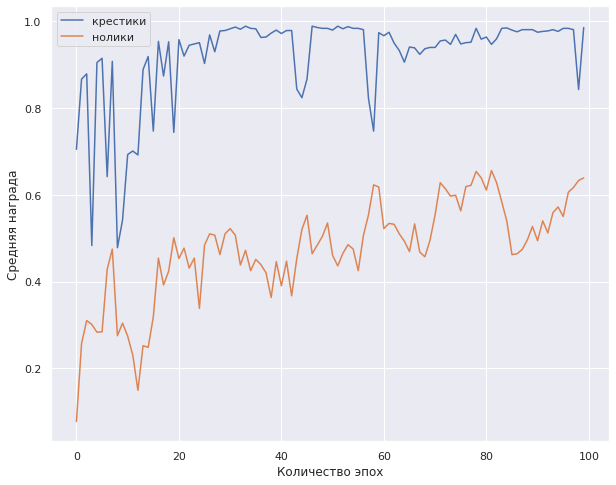

In [ ]:
plot_res_results_Q(iters, rew_x, rew_0)

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 4х4 и/или 5х5

In [ ]:
nrows, ncols, nwins = 4, 4, 4
env = TicTacToe(nrows, nwins, nwins)
train_q = Train_Q(env, alpha=.05, gamma=0.99, eps=.5)
Q_4x4, rew_x_4, rew_0_4, iters_4 = train_q.train_q(epoch=100, iter_per_epoch=20000, eval_iter=1000)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0, rewards крестики = 0.502, rewards нули = 0.292
epoch:10, rewards крестики = 0.695, rewards нули = 0.279
epoch:20, rewards крестики = 0.839, rewards нули = 0.378
epoch:30, rewards крестики = 0.802, rewards нули = 0.423
epoch:40, rewards крестики = 0.869, rewards нули = 0.445
epoch:50, rewards крестики = 0.892, rewards нули = 0.415
epoch:60, rewards крестики = 0.892, rewards нули = 0.487
epoch:70, rewards крестики = 0.901, rewards нули = 0.464
epoch:80, rewards крестики = 0.908, rewards нули = 0.54
epoch:90, rewards крестики = 0.904, rewards нули = 0.567


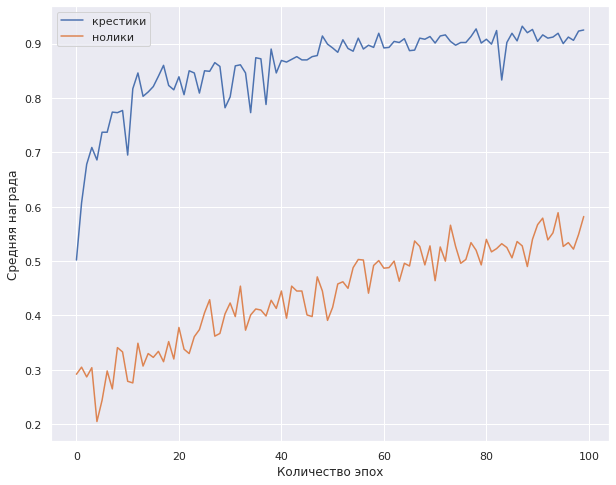

In [ ]:
plot_res_results_Q(iters_4, rew_x_4, rew_0_4)

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

## 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class Network(nn.Module):
    def __init__(self, state_dim=128, shape=3):
        nn.Module.__init__(self)
        self.conv_ = nn.Conv2d(3, state_dim * 2, (shape, shape))
        self.lin_ = nn.Linear(state_dim * 2, state_dim * 2)
        self.e = nn.Linear(state_dim * 2, shape * shape)

    def forward(self, x):
        x = F.relu(self.conv_(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin_(x))
        x = self.e(x)
        return x

In [ ]:
class DQN():
    def __init__(self, models, n_rows=3, n_cols=3, n_win=3, gamma=0.8, lr=1e-4, weight_decay=1e-3, batch_size=256):
        # print(n_rows)
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
        self.models = {-1: models[0].to(self.device), 1: models[1].to(self.device)}

        self.memories = {-1: ReplayMemory(1000000), 1: ReplayMemory(1000000)}
        self.optimizers = {-1: optim.Adam(self.models[-1].parameters(), lr=lr, weight_decay=weight_decay),
                           1: optim.Adam(self.models[1].parameters(), lr=lr, weight_decay=weight_decay)}
        self.s_prev = {-1: None, 1: None}
        self.prev_act = {}
        self.steps_done = 0
        self.gamma = gamma
        self.batch_size = batch_size

        self.num_step = 0

    def __state_to_tensor(self, state):
        state_int = np.array([int(char) for char in state])
        return torch.Tensor(np.stack([np.where(state_int==2, 1, 0).reshape(self.n_rows, self.n_rows),
                                      np.where(state_int==0, 1, 0).reshape(self.n_rows, self.n_rows), 
                                      np.where(state_int==1, 1, 0).reshape(self.n_rows, self.n_rows)])).reshape(3, 
                                                                                                                self.n_rows,
                                                                                                                self.n_rows)

    def __select_greedy_action(self, state, cur_turn):
        return self.models[cur_turn](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def __select_action(self, state, cur_turn):
        sample = np.random.random()
        self.num_step += 1
        eps_threshold = 0.05 + (0.9 - 0.05) * np.exp(-1. * self.num_step / 100000)
        if sample > eps_threshold:
            return self.__select_greedy_action(state, cur_turn)
        else:
            return torch.tensor([[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64)

    def update(self, greedy=False):
        self.env.reset()
        done = False
        self.s_prev = {-1: None, 1: None}
        self.prev_act = {}
        state, self.empty_spaces, cur_turn = self.env.getState()
        while not done:
            state_tensor = self.__state_to_tensor(state)
            with torch.no_grad():
                if greedy:
                    index = self.__select_greedy_action(state_tensor.to(self.device), cur_turn).cpu()
                else:
                    index = self.__select_action(state_tensor.to(self.device), cur_turn).cpu()

            self.s_prev[cur_turn] = state_tensor
            self.prev_act[cur_turn] = index
            action = self.env.action_from_int(index.numpy()[0][0])
            (next_state, empty_spaces, next_cur_turn), reward, done, _ = self.env.step(action)
            next_state_tensor = self.__state_to_tensor(next_state)

            if done == True:
                if reward == -10:
                    transition = (state_tensor, index, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                    self.memories[cur_turn].store(transition)
                else:
                    transition = (
                        state_tensor, index, next_state_tensor, torch.tensor([abs(reward)], dtype=torch.float32))
                    self.memories[cur_turn].store(transition)
                    transition = (self.s_prev[next_cur_turn], self.prev_act[next_cur_turn], next_state_tensor,
                                  torch.tensor([next_cur_turn * reward], dtype=torch.float32))
                    self.memories[next_cur_turn].store(transition)
            else:
                if self.s_prev[next_cur_turn] is not None:
                    transition = (self.s_prev[next_cur_turn], self.prev_act[next_cur_turn], next_state_tensor,
                                  torch.tensor([reward * next_cur_turn], dtype=torch.float32))
                    self.memories[next_cur_turn].store(transition)

            self.act(next_cur_turn)

            state = next_state
            cur_turn = next_cur_turn

    def act(self, cur_turn):
        if np.min([len(self.memories[cur_turn]), len(self.memories[-cur_turn])]) < self.batch_size:
            return


        transitions = self.memories[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))

        Q = self.models[cur_turn](batch_state)
        Q = Q.gather(1, batch_action).reshape([self.batch_size])

        Qmax = self.models[cur_turn](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        loss = F.huber_loss(Q, Qnext)
        self.optimizers[cur_turn].zero_grad()
        loss.backward()

        self.optimizers[cur_turn].step()

    def evaluate_policy(self, player, n_episodes=1000):
        rewards = []
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_spaces, cur_turn = self.env.getState()
            done = False
            while not done:
                if cur_turn == player:
                    idx = self.__select_greedy_action(self.__state_to_tensor(state).to(self.device), player)
                    action = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    action = empty_spaces[idx]
                (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            if reward != -10:
                rewards.append(reward * player)
            else:
                if cur_turn == player:
                    rewards.append(reward)
        return np.array(rewards)


In [ ]:
def train_dqn(fit, epochs, period):
      crestik_win = []
      zero_win = [] 
      periuds = []
      for epoch in tqdm(range(epochs)):
            fit.update()
            if epoch % period == 0:
                crosses = fit.evaluate_policy(1, period)
                zeros = fit.evaluate_policy(-1, period)
                crestik_win.append(np.sum(crosses==1)/period)
                zero_win.append(np.sum(zeros==1)/period)
                periuds.append(epoch)
      return crestik_win, zero_win, periuds

In [ ]:
def plot_res_results(crosses, zeros, periods):
    plt.figure(figsize=(10, 8))
    sns.set_theme(style="darkgrid")
    # sns.lineplot(crosses, label='крестики')
    sns.lineplot(x=periods, y=crosses, markers=True, label='крестики')
    sns.lineplot(x=periods, y=zeros, markers=True, label='нолики')
    plt.xlabel('Количество эпох')
    plt.ylabel('Средняя награда')

### DQN для игры 3x3

In [ ]:
net_zero = Network()
net_x = Network()
DQN_3x3 = DQN([net_zero, net_x], n_rows=3, n_cols=3, n_win=3)
crosses_3, zeros_3, periods_3 = train_dqn(DQN_3x3, 30000, 1000)


  0%|          | 0/30000 [00:00<?, ?it/s]

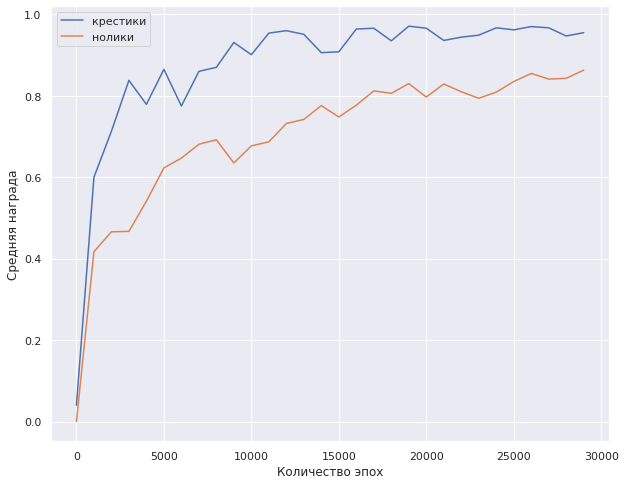

In [ ]:
plot_res_results(crosses_3, zeros_3, periods_3)

### DQN для игры 4x4

In [ ]:
net_zero = Network(shape=4)
net_x = Network(shape=4)
DQN_4x4 = DQN([net_zero, net_x], n_rows=4, n_cols=4, n_win=4)
crosses_4, zeros_4, periods_4 = train_dqn(DQN_4x4,  30000, 1000)


  0%|          | 0/30000 [00:00<?, ?it/s]

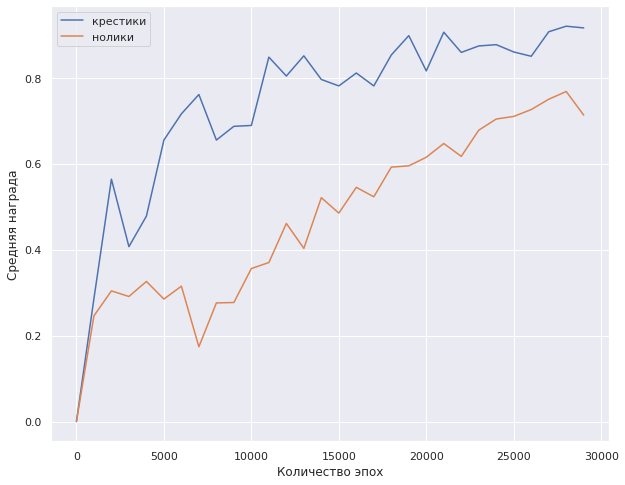

In [ ]:
plot_res_results(crosses_4, zeros_4, periods_4)

## 4. Реализуйте Double DQN и/или Dueling DQN.

In [ ]:
class dueling_network(nn.Module):
    def __init__(self, state_dim=128, shape=3):
        nn.Module.__init__(self)
        self.conv_ = nn.Conv2d(3, state_dim * 2, (shape, shape))
        self.lin_ = nn.Linear(state_dim * 2, state_dim * 2)
        self.lin_2 = nn.Linear(state_dim * 2, 1)
        self.e = nn.Linear(state_dim * 2, shape * shape)

    def forward(self, x):
        x = F.relu(self.conv_(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin_(x))
        l = self.lin_2(x)
        e = self.e(x)
        qvals = l + (e - e.mean(dim=1, keepdim=True))
        return qvals

### Dueling DQN для игры 3x3


In [ ]:
nn_zeros = dueling_network(shape=3)
nn_crosses = dueling_network(shape=3)
DNQ_3x3 = DQN([nn_zeros, nn_crosses], 3, 3, 3)
d_crosses_3, d_zeros_3, periods_d_3 = train_dqn(DNQ_3x3,  30000, 1000)

  0%|          | 0/30000 [00:00<?, ?it/s]

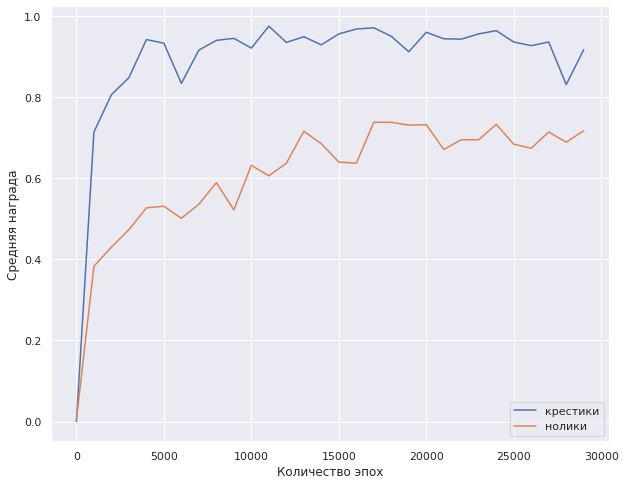

In [ ]:
plot_res_results(d_crosses_3, d_zeros_3, periods_d_3)

### Dueling DQN для игры 4x4

In [ ]:
nn_zeros = dueling_network(shape = 4)
nn_crosses = dueling_network(shape = 4)
DNQ_4x4 = DQN([nn_zeros, nn_crosses], 4, 4, 4)
d_crosses_4, d_zeros_4, periods_d_4 = train_dqn(DNQ_4x4,  30000, 1000)


  0%|          | 0/30000 [00:00<?, ?it/s]

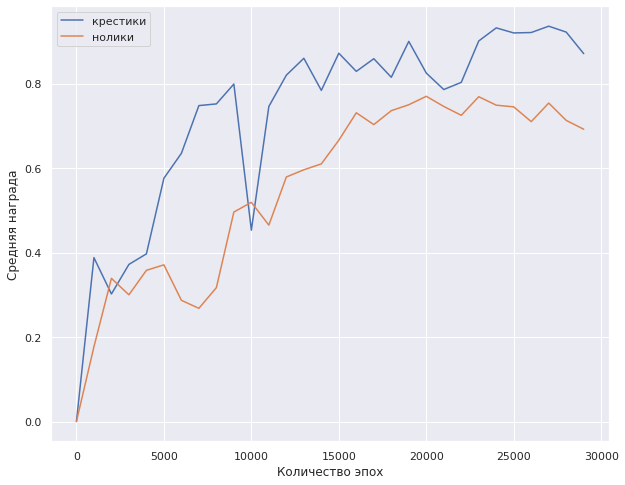

In [ ]:
plot_res_results(d_crosses_4, d_zeros_4, periods_d_4)

# Часть третья: 